
�� Analyse : Testvide1.wav (start=4s)
✅ tau = 6.091 ± 0.007 s


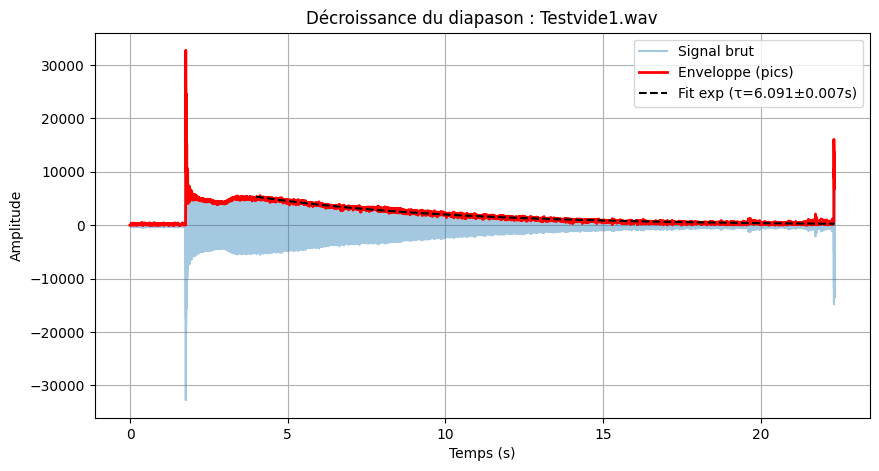


�� Analyse : Testvide2.wav (start=4s)
✅ tau = 6.529 ± 0.002 s


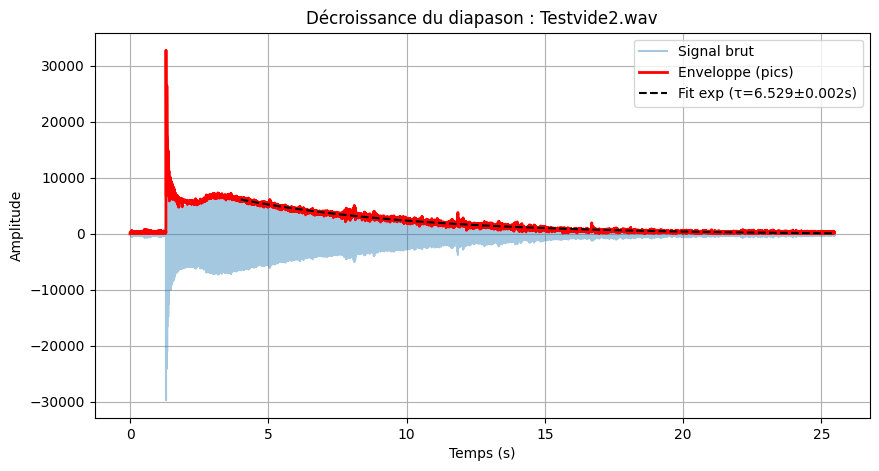


�� Analyse : Testvide3.wav (start=4s)
✅ tau = 8.536 ± 0.005 s


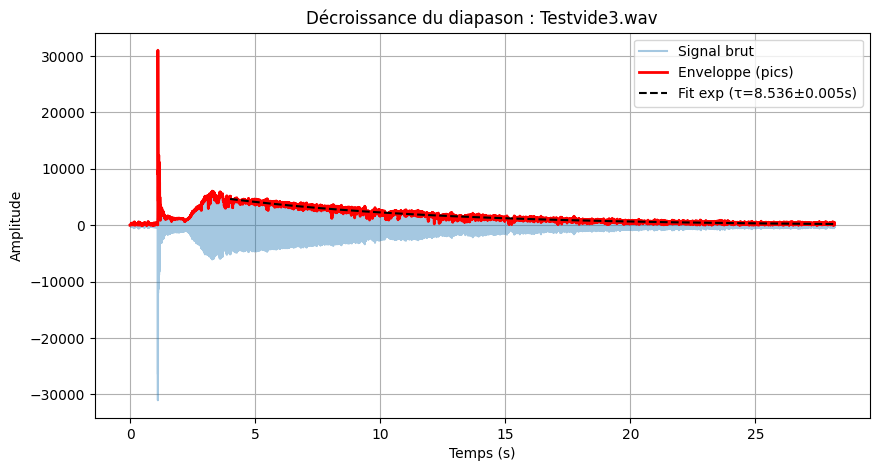


�� Analyse : Testvide4.wav (start=4s)
✅ tau = 6.164 ± 0.003 s


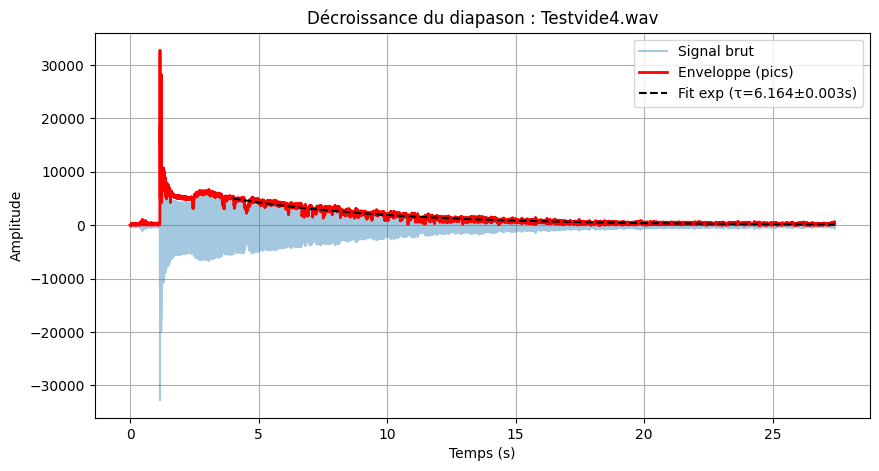


--- Résumé des τ ---
Testvide1.wav : τ = 6.091 ± 0.007 s
Testvide2.wav : τ = 6.529 ± 0.002 s
Testvide3.wav : τ = 8.536 ± 0.005 s
Testvide4.wav : τ = 6.164 ± 0.003 s


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os

# -----------------------------
# 1️⃣ Lecture du fichier wav
# -----------------------------
def load_wav(filepath):
    """Charge un fichier WAV et retourne le temps, le signal et la fréquence d'échantillonnage."""
    sr, data = wavfile.read(filepath)
    if len(data.shape) > 1:  # si stéréo → mono
        data = data[:, 0]
    data = data.astype(float)
    t = np.arange(len(data)) / sr
    return t, data, sr

# -----------------------------
# 2️⃣ Calcul de la vraie enveloppe
# -----------------------------
def compute_real_envelope(y, sr, min_distance_ms=2):
    """
    Construit une enveloppe en reliant les pics du signal.
    Utilise scipy.signal.find_peaks pour détecter les maxima locaux.
    """
    distance = int(sr * min_distance_ms / 1000)  # conversion ms → échantillons
    peaks, _ = find_peaks(np.abs(y), distance=distance)
    if len(peaks) < 2:
        print("⚠️ Trop peu de pics détectés, enveloppe approximative")
        return np.abs(y)
    env = np.interp(np.arange(len(y)), peaks, np.abs(y[peaks]))
    return env

# -----------------------------
# 3️⃣ Modèle exponentiel
# -----------------------------
def exp_decay(t, A, tau, C):
    """Modèle : A * exp(-t/tau) + C"""
    return A * np.exp(-t / tau) + C

# -----------------------------
# 4️⃣ Ajustement exponentiel avec incertitude
# -----------------------------
def fit_decay(t, env, start_time=None, sr=None):
    """
    Ajuste une exponentielle à l'enveloppe du signal
    et renvoie τ avec son incertitude (erreur-type).
    """
    if start_time is not None:
        start_idx = int(start_time * sr)
    else:
        start_idx = np.argmax(env)  # début automatique si non spécifié

    # Fin : quand le signal tombe sous 5 % de la valeur max
    threshold = np.max(env[0:10]) * 0.05
    end_candidates = np.where(env[start_idx:] < threshold)[0]
    end_idx = start_idx + end_candidates[0] if len(end_candidates) > 0 else len(env)

    t_fit = t[start_idx:end_idx]
    env_fit = env[start_idx:end_idx]

    if len(t_fit) < 10:
        print("⚠️ Signal trop court pour fit")
        return None

    try:
        popt, pcov = curve_fit(exp_decay, t_fit, env_fit, p0=(env_fit[0], 0.5, 0))
        A, tau, C = popt
        perr = np.sqrt(np.diag(pcov))  # erreurs-types sur A, tau, C
        tau_err = perr[1]
        print(f"✅ tau = {tau:.3f} ± {tau_err:.3f} s")
        return A, tau, C, tau_err, t_fit, env_fit
    except RuntimeError:
        print("⚠️ Échec de l'ajustement exponentiel")
        return None

# -----------------------------
# 5️⃣ Analyse et visualisation
# -----------------------------
def analyze_wav(filepath, start_time=None, min_distance_ms=2):
    """
    Analyse complète d'un fichier audio :
    - extraction de l'enveloppe
    - fit exponentiel
    - affichage du graphique
    """
    t, y, sr = load_wav(filepath)
    env = compute_real_envelope(y, sr, min_distance_ms=min_distance_ms)
    fit = fit_decay(t, env, start_time=start_time, sr=sr)

    plt.figure(figsize=(10, 5))
    plt.plot(t, y, alpha=0.4, label="Signal brut")
    plt.plot(t, env, 'r', linewidth=2, label="Enveloppe (pics)")

    if fit is not None:
        A, tau, C, tau_err, t_fit, env_fit = fit
        plt.plot(t_fit, exp_decay(t_fit, A, tau, C),
                 'k--', label=f"Fit exp (τ={tau:.3f}±{tau_err:.3f}s)")

    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Décroissance du diapason : {os.path.basename(filepath)}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return fit

# -----------------------------
# 6️⃣ Analyse de plusieurs fichiers
# -----------------------------
files = [
    ("Testvide1.wav", 4),
    ("Testvide2.wav", 4),
    ("Testvide3.wav", 4),
    ("Testvide4.wav", 4)
]

results = {}

for f, start_time in files:
    print(f"\n�� Analyse : {f} (start={start_time}s)")
    fit = analyze_wav(f, start_time=start_time)
    if fit is not None:
        A, tau, C, tau_err, _, _ = fit
        results[f] = (tau, tau_err)

# -----------------------------
# 7️⃣ Résumé final
# -----------------------------
print("\n--- Résumé des τ ---")
for f, (tau, tau_err) in results.items():
    print(f"{f} : τ = {tau:.3f} ± {tau_err:.3f} s")